In [1]:
import json, os, sys

from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns

project_dir = os.path.abspath("..")
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)
    
import utils
import result_helper


sns.set(style="whitegrid")

In [2]:
skadi_job_paths = list(Path("../data/experiments-skadi/").glob("**/job-info.json"))
odin_job_paths = list(Path("../data/experiments-odin/").glob("**/job-info.json"))

job_paths = skadi_job_paths + odin_job_paths

df_data = result_helper.get_result_summary(job_paths)

cols_irrelavant = [
    "started_at", "completed_at", "precision_score", "recall_score", "f1_score", "random_seed",
    'experiment_type', 'experiment_name', 'component_size', 'variance', 'label_noise_proba',
    'allow_self_loops', 'distance_metric', 'job_path', 'duration_secs'
]
cols_relevant = list(set(df_data.columns) - set(cols_irrelavant))

## Introduction

### Purpose of the experiments

- Determine how to parameterize the data generator and the algorithm in order to fully recover the mixtures
  - How many steps should the random walker take before it stops?
  - What is the minimum separation?
  - How does the labelling information influence the performance?



### Data generation

- Place the Gaussian centers on a $k$-dimensional simplex i.e., standard unit basis vectors in $k$ dimensions
  - Number of Gaussian components $k$ is the same as the number of dimensions $d$
- Move the centers by multiplying them with a factor: `min_distance`.
- Number of points in each Gaussian component: 50
- Variance in each component: 1
- No label noise added - to figure out how the algorithm behaves in the best case
- No self-loops


## No labelling information $\beta = 1$

### Impact of number of steps on constant separation $2$

Experiment parameters:
- $\beta = 1$
- Number of steps: 1-100
- Separation: 2

In [3]:
filter_dim_steps_no_bias_01 = df_data.experiment_name == "dim_steps_no_bias_01"
df_ff = df_data[(filter_dim_steps_no_bias_01)].copy()

df_grouped = df_ff.groupby(["n_dim", "n_steps"])[["accuracy_score"]].mean().reset_index()
df_grouped.pivot(index=["n_steps"], columns=["n_dim"], values=["accuracy_score"])

accuracy_score                    
n_dim              10        50        100
n_steps                                   
1             0.586400  0.101867  0.060678
5             0.368800  0.093559  0.058902
10            0.334323  0.088828  0.056960
20            0.298733  0.067035  0.052149
50            0.160710  0.066381  0.051666
100           0.158619  0.063210  0.050928

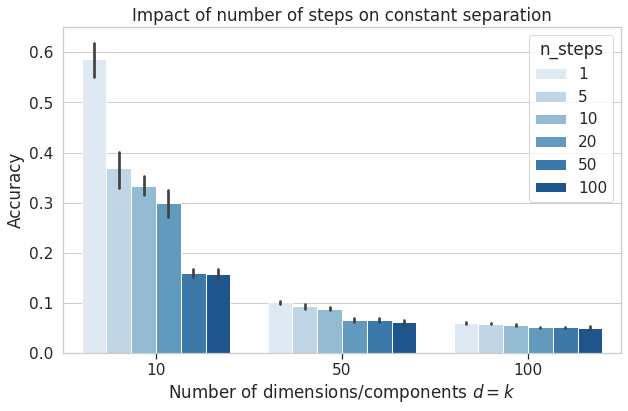

In [4]:
df_data_filtered = df_data[filter_dim_steps_no_bias_01].copy()
df_data_filtered = df_data_filtered.sort_values(["min_distance", "n_dim", "bias_factor", "n_steps"])

with sns.plotting_context("notebook", font_scale=1.4):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(
        x="n_dim",y="accuracy_score", hue="n_steps",
        data=df_data_filtered,palette="Blues", ax=ax
    )
    ax.yaxis.grid(True)
    ax.yaxis.set_minor_locator(ticker.LinearLocator(numticks=10))
    ax.tick_params(which="both", bottom=True)
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Number of dimensions/components $d=k$")
    ax.set_title(f"Impact of number of steps on constant separation");
    # ax.set_ylim([0, 1])

- It seems that a single-step random walk is best

### Impact of separation $c k^{\frac{1}{4}}$ on 5-step random walk

Experiment parameters:
- Separation: $c \cdot k^{1/4}$ where $c \in \{ 3, 4, 5, 6 \}$
- $\beta = 1$
- Number of random walk steps: 5

In [5]:
f_no_bias_01 = df_data.experiment_name == "no_bias_01"
df_ff = df_data[f_no_bias_01].copy()
df_ff["c"] = df_ff.groupby("n_dim")[["min_distance"]].rank("dense").astype(int) + 2

df_grouped = df_ff.groupby(["n_dim", "c", "min_distance"])[["accuracy_score"]].mean().reset_index()
df_grouped.pivot(index=["c"], columns=["n_dim"], values=["accuracy_score"])

accuracy_score                              
n_dim            10        50        100       200
c                                                 
3                1.0  0.978855  0.961538  0.947969
4                1.0  1.000000  0.990196  0.980392
5                1.0  1.000000  1.000000  0.995050
6                1.0  1.000000  1.000000  1.000000

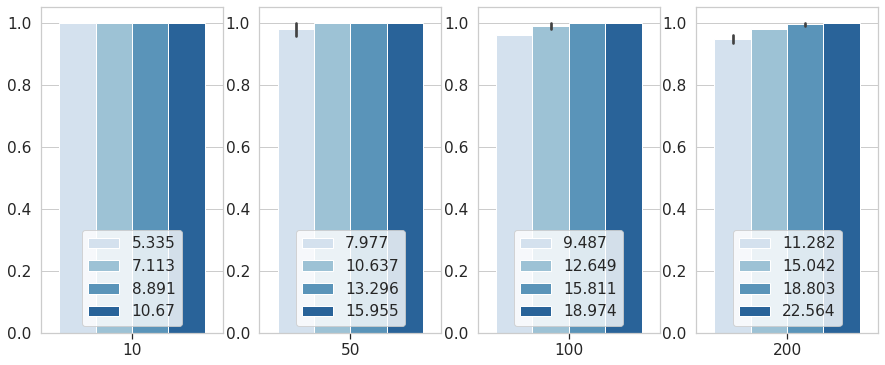

In [6]:
with sns.plotting_context("notebook", font_scale=1.4):
    fig, axes = plt.subplots(ncols=4, figsize=(15, 6))
    for i, n_dim in enumerate([10, 50, 100, 200]):
        
        filter_dim = df_data.n_dim == n_dim
        df_data_filtered = df_data[f_no_bias_01 & filter_dim].copy()
        df_data_filtered = df_data_filtered.sort_values(["min_distance", "n_dim", "bias_factor", "n_steps"])
        df_data_filtered["min_distance"] = df_data_filtered["min_distance"].round(3)
        
        if df_data_filtered.shape[0] == 0:
            print(f"No data for d={n_dim}")
            continue
        
        sns.barplot(
            x="n_dim",y="accuracy_score", hue="min_distance",
            data=df_data_filtered,palette="Blues", ax=axes[i]
        )
        #ax.legend(title='Bias factor: $\\beta$', loc='upper left', labels=['1/4', '1/8', '1/16', '1/32'])
        axes[i].yaxis.grid(True)
        axes[i].yaxis.set_minor_locator(ticker.LinearLocator(numticks=10))
        axes[i].tick_params(which="both", bottom=True)
        axes[i].set_ylabel("")
        axes[i].set_xlabel("")
        axes[i].set_xlabel("")
        axes[i].legend(loc='lower center')
        axes[i].set_title(f"");

        # ax.set_ylim([0, 1])

### Impact of number of steps on separation $3k^{\frac{1}{4}}$

Experiment parameters:
- $\beta = 1$
- Separation: $3 k^{\frac{1}{4}} $

In [7]:
filter_no_bias_02 = df_data.experiment_name == "no_bias_02"
df_ff = df_data[(filter_no_bias_02)].copy()

df_grouped = df_ff.groupby(["n_dim", "n_steps"])[["accuracy_score"]].mean().reset_index()
df_grouped.pivot(index=["n_steps"], columns=["n_dim"], values=["accuracy_score"])

accuracy_score                    
n_dim              10        50        100
n_steps                                   
1                1.000  1.000000  0.980392
5                1.000  0.957774  0.961538
10               1.000  0.954650  0.941920
20               0.998  0.833526  0.055508
50               0.986  0.066788  0.051994
100              0.900  0.072076  0.052249

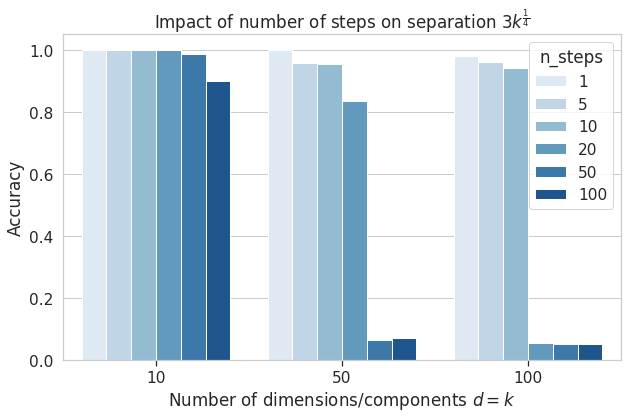

In [8]:
df_data_filtered = df_data[filter_no_bias_02].copy()
df_data_filtered = df_data_filtered.sort_values(["min_distance", "n_dim", "bias_factor", "n_steps"])

with sns.plotting_context("notebook", font_scale=1.4):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(
        x="n_dim",y="accuracy_score", hue="n_steps",
        data=df_data_filtered,palette="Blues", ax=ax
    )
    ax.yaxis.grid(True)
    ax.yaxis.set_minor_locator(ticker.LinearLocator(numticks=10))
    ax.tick_params(which="both", bottom=True)
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Number of dimensions/components $d=k$")
    ax.set_title("Impact of number of steps on separation $3k^{\\frac{1}{4}}$");
    # ax.set_ylim([0, 1])

### Impact of number of steps on separation $5k^{\frac{1}{4}}$

Experiment parameters:
- $\beta = 1$
- Separation: $5 k^{\frac{1}{4}} $

In [9]:
filter_no_bias_03 = df_data.experiment_name == "no_bias_03"
df_ff = df_data[(filter_no_bias_03)].copy()

df_grouped = df_ff.groupby(["n_dim", "n_steps"])[["accuracy_score"]].mean().reset_index()
df_grouped.pivot(index=["n_steps"], columns=["n_dim"], values=["accuracy_score"])

accuracy_score               
n_dim              10   50        100
n_steps                              
1                  1.0  1.0  1.000000
5                  1.0  1.0  1.000000
10                 1.0  1.0  1.000000
20                 1.0  1.0  0.980392
50                 1.0  1.0  0.257018
100                1.0  1.0  0.071890

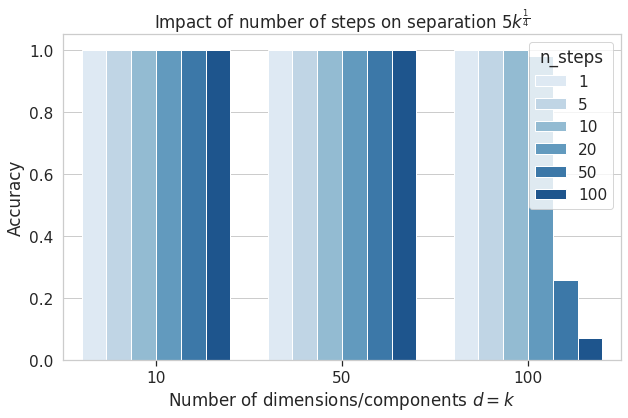

In [10]:
df_data_filtered = df_data[filter_no_bias_03].copy()
df_data_filtered = df_data_filtered.sort_values(["min_distance", "n_dim", "bias_factor", "n_steps"])

with sns.plotting_context("notebook", font_scale=1.4):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(
        x="n_dim",y="accuracy_score", hue="n_steps",
        data=df_data_filtered,palette="Blues", ax=ax
    )
    ax.yaxis.grid(True)
    ax.yaxis.set_minor_locator(ticker.LinearLocator(numticks=10))
    ax.tick_params(which="both", bottom=True)
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Number of dimensions/components $d=k$")
    ax.set_title("Impact of number of steps on separation $5 k^{\\frac{1}{4}}$");
    # ax.set_ylim([0, 1])

### Impact of number of steps on separation $7k^{\frac{1}{4}}$

Experiment parameters:
- $\beta = 1$
- Separation: $7 k^{\frac{1}{4}} $

In [11]:
filter_no_bias_04 = df_data.experiment_name == "no_bias_04"
df_ff = df_data[(filter_no_bias_04)].copy()

df_grouped = df_ff.groupby(["n_dim", "n_steps"])[["accuracy_score"]].mean().reset_index()
df_grouped.pivot(index=["n_steps"], columns=["n_dim"], values=["accuracy_score"])

accuracy_score          
n_dim              10   50   100
n_steps                         
1                  1.0  1.0  1.0
5                  1.0  1.0  1.0
10                 1.0  1.0  1.0
20                 1.0  1.0  1.0
50                 1.0  1.0  1.0
100                1.0  1.0  1.0

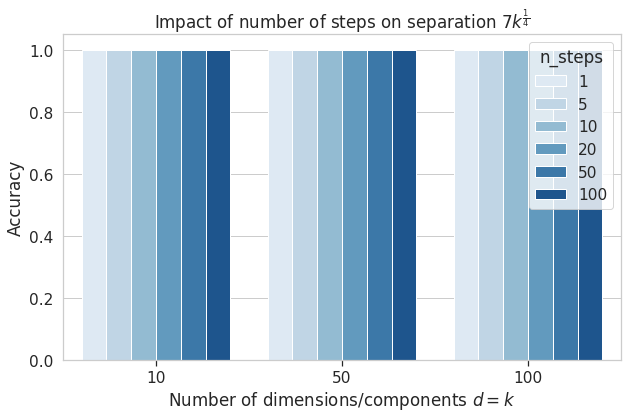

In [12]:
df_data_filtered = df_data[filter_no_bias_04].copy()
df_data_filtered = df_data_filtered.sort_values(["min_distance", "n_dim", "bias_factor", "n_steps"])

with sns.plotting_context("notebook", font_scale=1.4):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(
        x="n_dim",y="accuracy_score", hue="n_steps",
        data=df_data_filtered,palette="Blues", ax=ax
    )
    ax.yaxis.grid(True)
    ax.yaxis.set_minor_locator(ticker.LinearLocator(numticks=10))
    ax.tick_params(which="both", bottom=True)
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Number of dimensions/components $d=k$")
    ax.set_title("Impact of number of steps on separation $7 k^{\\frac{1}{4}}$");
    # ax.set_ylim([0, 1])

### Impact of separation $c k^{\frac{1}{4}}$ on single-step random walk

Experiment parameters:
- $\beta = 1$
- Separation: $c k^{\frac{1}{4}} $ where $c \in \{ 1, 2, 3, 4, 5, 6 \}$
- Number of steps: 1

In [13]:
f_no_bias_single_step_01 = df_data.experiment_name == "no_bias_single_step_01"
df_ff = df_data[f_no_bias_single_step_01].copy()
df_ff["c"] = df_ff.groupby("n_dim")[["min_distance"]].rank("dense").astype(int)

df_grouped = df_ff.groupby(["n_dim", "c", "min_distance"])[["accuracy_score"]].mean().reset_index()
df_grouped.pivot(index=["c"], columns=["n_dim"], values=["accuracy_score"])

accuracy_score                                        
n_dim            10        50        100       200       300
c                                                           
1           0.448762  0.166946  0.093286  0.063846  0.051306
2           0.955000  0.969247  0.945774  0.887908  0.829195
3           0.999500  0.990385  0.944368  0.937032  0.854533
4           1.000000  1.000000  1.000000  0.975726  0.937773
5           1.000000  1.000000  1.000000  0.997525  0.985418
6           1.000000  1.000000  1.000000  1.000000  1.000000

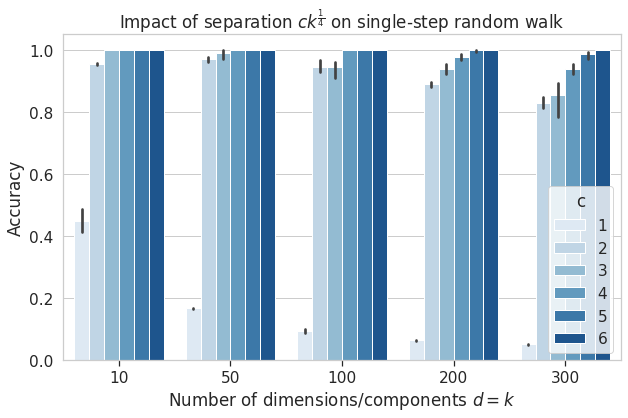

In [14]:
with sns.plotting_context("notebook", font_scale=1.4):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(
        x="n_dim",y="accuracy_score", hue="c",
        data=df_ff, palette="Blues", ax=ax
    )
    ax.yaxis.grid(True)
    ax.yaxis.set_minor_locator(ticker.LinearLocator(numticks=10))
    ax.tick_params(which="both", bottom=True)
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Number of dimensions/components $d=k$")
    ax.set_title("Impact of separation $ck^{\\frac{1}{4}}$ on single-step random walk");
    # ax.set_ylim([0, 1])

### Impact of separation $\ln(k)\cdot k^{\frac{1}{4}} $ on single-step random walk
-----

Experiment parameters:
- $\beta = 1$
- Separation: $(c+\ln(k)) \cdot k^{\frac{1}{4}} $ where $c = \{ 0.5, 1.0, 1.5, 2.0  \}$
- Number of steps: 1

In [15]:
f_no_bias_single_step_02 = df_data.experiment_name == "no_bias_single_step_02"
f_no_bias_single_step_03 = df_data.experiment_name == "no_bias_single_step_03"
f_no_bias_single_step_04 = df_data.experiment_name == "no_bias_single_step_04"
df_ff = df_data[f_no_bias_single_step_02 | f_no_bias_single_step_03 | f_no_bias_single_step_04].copy()
df_ff["c"] = df_ff.groupby("n_dim")[["min_distance"]].rank("dense").astype(int) / 2 - 0.5

df_grouped = df_ff.groupby(["n_dim", "c", "min_distance"])[["accuracy_score"]].mean().reset_index()
df_grouped.pivot(index=["c"], columns=["n_dim"], values=["accuracy_score"])

accuracy_score                              
n_dim            10   50   100       200       300
c                                                 
0.0           0.9780  1.0  1.0  0.997525  0.996689
0.5           0.9952  1.0  1.0  1.000000  0.998675
1.0           1.0000  1.0  1.0  1.000000  1.000000
1.5           1.0000  1.0  1.0  1.000000  1.000000
2.0           1.0000  1.0  1.0  1.000000  1.000000

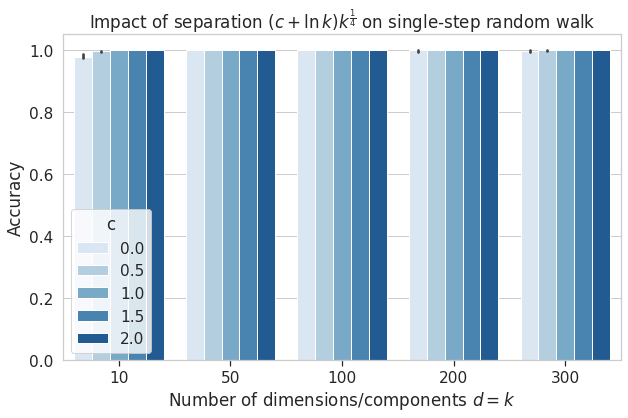

In [16]:
with sns.plotting_context("notebook", font_scale=1.4):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(
        x="n_dim",y="accuracy_score", hue="c",
        data=df_ff, palette="Blues", ax=ax
    )
    ax.yaxis.grid(True)
    ax.yaxis.set_minor_locator(ticker.LinearLocator(numticks=10))
    ax.tick_params(which="both", bottom=True)
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Number of dimensions/components $d=k$")
    ax.set_title("Impact of separation $(c+\ln{k})k^{\\frac{1}{4}}$ on single-step random walk");
    # ax.set_ylim([0, 1])

### Impact of separation $\log_{10}(k)\cdot k^{\frac{1}{4}} $ on single-step random walk

Experiment parameters:
- $\beta = 1$
- Separation: $(c+\log_{10}(k)) \cdot k^{\frac{1}{4}} $ where $c = \{ 1, 2, 3 \}$
- Number of steps: 1

In [17]:
f_no_bias_single_step_log10_01 = df_data.experiment_name == "no_bias_single_step_log10_01"
df_ff = df_data[f_no_bias_single_step_log10_01].copy()
df_ff["c"] = df_ff.groupby("n_dim")[["min_distance"]].rank("dense").astype(int)

df_grouped = df_ff.groupby(["n_dim", "c", "min_distance"])[["accuracy_score"]].mean().reset_index()
df_grouped.pivot(index=["c"], columns=["n_dim"], values=["accuracy_score"])

accuracy_score                                        
n_dim            10        50        100       200       300
c                                                           
1              0.959  0.974108  0.974108  0.937518  0.918398
2              0.998  1.000000  1.000000  0.977282  0.978545
3              1.000  1.000000  1.000000  1.000000  0.991257

### Impact of variance on single-step random walk
---

Experiment parameters:
- $\beta = 1$
- Separation: $(3+\log_{10}(k)) \cdot k^{\frac{1}{4}}$
- Number of steps: 1
- Variance: 2 or 3

In [18]:
f_no_bias_single_step_var_01 = df_data.experiment_name == "no_bias_single_step_var_01"
f_no_bias_single_step_var_02 = df_data.experiment_name == "no_bias_single_step_var_02"
f_no_bias_single_step_var_03 = df_data.experiment_name == "no_bias_single_step_var_03"
df_ff = df_data[f_no_bias_single_step_var_01 | f_no_bias_single_step_var_02 | f_no_bias_single_step_var_03].copy()

df_grouped = df_ff.groupby(["n_dim", "variance"])[["accuracy_score"]].mean().reset_index()
df_grouped.pivot(index=["variance"], columns=["n_dim"], values=["accuracy_score"])


accuracy_score                                        
n_dim               10        50        100       200       300
variance                                                       
2.0              0.9972  0.992308  0.988235  0.992079  0.989021
3.0              0.9820  0.976923  0.966252  0.988158  0.944082
4.0              0.9372  0.949735  0.950788  0.964618       NaN
5.0              0.8068  0.938558  0.937455  0.955433       NaN
6.0              0.7556  0.913478  0.938948  0.914683       NaN
8.0              0.5180       NaN       NaN       NaN       NaN

### Impact of variance dependent separation on single-step random walk
---

Experiment parameters:
- $\beta = 1$
- Separation: $\sigma^2 \cdot (3+\log_{10}(k)) \cdot k^{\frac{1}{4}}$ 
- Number of steps: 1
- Variance: 2 or 3

In [19]:
f_no_bias_single_step_var_04 = df_data.experiment_name == "no_bias_single_step_var_04"
df_ff = df_data[f_no_bias_single_step_var_04].copy()

df_grouped = df_ff.groupby(["n_dim", "variance"])[["accuracy_score"]].mean().reset_index()
df_grouped.pivot(index=["variance"], columns=["n_dim"], values=["accuracy_score"])


variance


### Impact of variance dependent separation on single-step random walk
---

Experiment parameters:
- $\beta = 1$
- Separation: $\sqrt{\sigma^2} \cdot (3+\log_{10}(k)) \cdot k^{\frac{1}{4}}$ 
- Number of steps: 1
- Variance: 2 or 3

In [20]:
f_no_bias_single_step_var_05 = df_data.experiment_name == "no_bias_single_step_var_05"
df_ff = df_data[f_no_bias_single_step_var_05].copy()

df_grouped = df_ff.groupby(["n_dim", "variance"])[["accuracy_score"]].mean().reset_index()
df_grouped.pivot(index=["variance"], columns=["n_dim"], values=["accuracy_score"])


variance


## Use of labelling information $\beta > 1$

### Impact of small $\beta$ on low constant separation

Experiment parameters:
- $\beta = k^{\frac{1}{m}}$ where $m = \{ 512, 256, 128, 64, 32, 16, 8, 4 \}$
- Number of steps: 10
- Separation: 2


In [21]:
filter_dim_bias_01 = df_data.experiment_name == "dim_bias_01"
filter_dim_bias_02 = df_data.experiment_name == "dim_bias_02"
filter_dim_bias_03 = df_data.experiment_name == "dim_bias_03"
filter_all = (filter_dim_bias_01 | filter_dim_bias_02 | filter_dim_bias_03)
df_ff = df_data[filter_all].copy()
df_ff["m"] = df_ff.groupby("n_dim")[["bias_factor"]].rank("dense", ascending=False).astype(int) + 3
df_ff.groupby(["n_dim", "m"])[["accuracy_score"]].mean().reset_index().pivot(index=["m"], columns=["n_dim"], values=["accuracy_score"])

accuracy_score                         
n_dim            10   50   100  200  250  300
m                                            
4                1.0  1.0  1.0  1.0  1.0  1.0
5                1.0  1.0  1.0  1.0  1.0  1.0
6                1.0  1.0  1.0  1.0  1.0  1.0
7                1.0  1.0  1.0  1.0  1.0  1.0
8                1.0  1.0  1.0  1.0  1.0  1.0
9                1.0  1.0  1.0  1.0  1.0  1.0
10               1.0  1.0  1.0  1.0  1.0  1.0
11               1.0  1.0  1.0  1.0  1.0  1.0

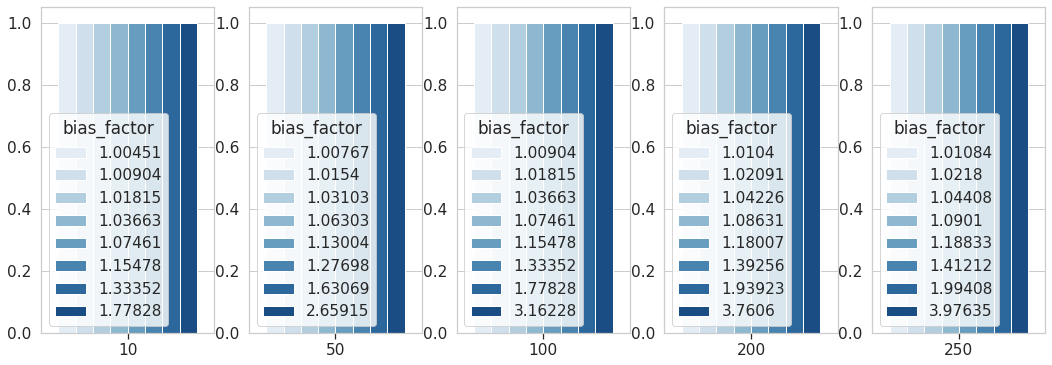

In [22]:
with sns.plotting_context("notebook", font_scale=1.4):
    fig, axes = plt.subplots(ncols=5, figsize=(18, 6))
    for i, n_dim in enumerate([10, 50, 100, 200, 250]):
        
        filter_dim = df_data.n_dim == n_dim
        df_data_filtered = df_data[filter_all & filter_dim].copy()
        df_data_filtered = df_data_filtered.sort_values(["min_distance", "n_dim", "bias_factor", "n_steps"])
        df_data_filtered["bias_factor"] = df_data_filtered["bias_factor"].round(5)
        
        sns.barplot(
            x="n_dim",y="accuracy_score", hue="bias_factor",
            data=df_data_filtered,palette="Blues", ax=axes[i]
        )
        #ax.legend(title='Bias factor: $\\beta$', loc='upper left', labels=['1/4', '1/8', '1/16', '1/32'])
        axes[i].yaxis.grid(True)
        axes[i].yaxis.set_minor_locator(ticker.LinearLocator(numticks=10))
        axes[i].tick_params(which="both", bottom=True)
        axes[i].set_ylabel("")
        axes[i].set_xlabel("")
        axes[i].set_title(f"");

        # ax.set_ylim([0, 1])

### Impact of a constant separation on a single-step random walk

Experiment parameters:
- $\beta = k^{1/4}$
- Number of random walk steps: 1

In [23]:
filter_dist_1 = df_data.experiment_name == "dim_dist_01"
filter_dist_2 = df_data.experiment_name == "dim_dist_02"
df_ff = df_data[(filter_dist_1 | filter_dist_2)].copy()

df_grouped = df_ff.groupby(["n_dim", "min_distance"])[["accuracy_score"]].mean().reset_index()
df_grouped.pivot(index=["min_distance"], columns=["n_dim"], values=["accuracy_score"])

accuracy_score                                                    \
n_dim                   10        50        100       150       200       250   
min_distance                                                                    
2.0                  0.8964  0.940680  0.956131  0.911189  0.926966  0.902874   
3.0                  0.9804  0.976923  0.947025  0.933710  0.923927  0.918165   
4.0                  0.9964  0.961538  0.961957  0.952158  0.956221  0.940320   
5.0                  0.9996  0.984615  0.965451  0.966597  0.943758  0.944291   
6.0                  1.0000  1.000000  0.972851  0.956977  0.965487  0.969016   
10.0                 1.0000  1.000000  1.000000  0.994737  0.990099  0.982787   

                        
n_dim              300  
min_distance            
2.0           0.912159  
3.0           0.909257  
4.0           0.948545  
5.0           0.925274  
6.0           0.934592  
10.0          0.977945

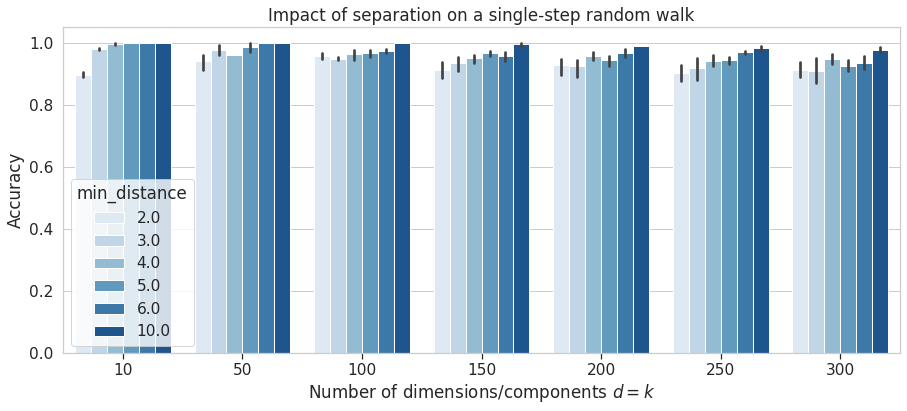

In [24]:

df_data_filtered = df_data[filter_dist_1 | filter_dist_2].copy()
df_data_filtered = df_data_filtered.sort_values(["min_distance", "n_dim", "bias_factor", "n_steps"])

with sns.plotting_context("notebook", font_scale=1.4):
    fig, ax = plt.subplots(figsize=(15, 6))
    sns.barplot(
        x="n_dim",y="accuracy_score",hue="min_distance",
        data=df_data_filtered,palette="Blues", ax=ax
    )
    ax.yaxis.grid(True)
    ax.yaxis.set_minor_locator(ticker.LinearLocator(numticks=10))
    ax.tick_params(which="both", bottom=True)
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Number of dimensions/components $d=k$")
    ax.set_title(f"Impact of separation on a single-step random walk");
    # ax.set_ylim([0, 1])

### Impact of short random walks

Experiment parameters: 
- $\beta = k^{1/4}$
- Separation: 2 or 3

In [25]:
filter_steps_01 = df_data.experiment_name == "dim_steps_01"
df_ff = df_data[(filter_steps_01)].copy()

df_grouped = df_ff.groupby(["n_dim", "n_steps"])[["accuracy_score"]].mean().reset_index()
df_grouped.pivot(index=["n_steps"], columns=["n_dim"], values=["accuracy_score"])

accuracy_score                                        
n_dim              10        50        100       150       200
n_steps                                                       
1               0.8900  0.899927  0.926809  0.919641  0.890005
2               0.9464  0.969231  0.984314  0.981850  0.988234
5               1.0000  1.000000  1.000000  1.000000  1.000000
10              1.0000  1.000000  1.000000  1.000000  1.000000

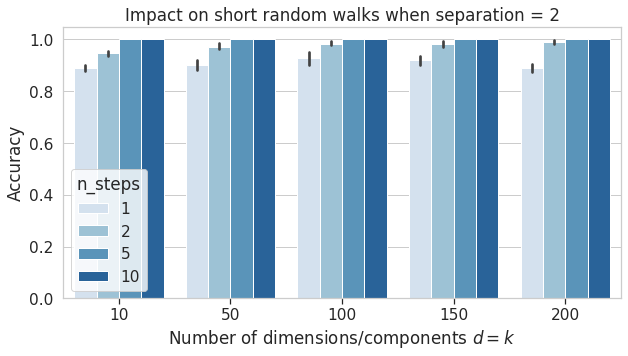

In [26]:
filter_steps_01 = df_data.experiment_name == "dim_steps_01"
df_data_filtered = df_data[filter_steps_01].copy()
df_data_filtered = df_data_filtered.sort_values(["min_distance", "n_dim", "bias_factor", "n_steps"])

with sns.plotting_context("notebook", font_scale=1.4):
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.barplot(
        x="n_dim",y="accuracy_score", hue="n_steps",
        data=df_data_filtered,palette="Blues", ax=ax
    )
    ax.yaxis.grid(True)
    ax.yaxis.set_minor_locator(ticker.LinearLocator(numticks=10))
    ax.tick_params(which="both", bottom=True)
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Number of dimensions/components $d=k$")
    ax.set_title(f"Impact on short random walks when separation = 2");
    # ax.set_ylim([0, 1])

In [27]:
filter_steps_01 = df_data.experiment_name == "dim_steps_02"
df_ff = df_data[(filter_steps_01)].copy()

df_grouped = df_ff.groupby(["n_dim", "n_steps"])[["accuracy_score"]].mean().reset_index()
df_grouped.pivot(index=["n_steps"], columns=["n_dim"], values=["accuracy_score"])

accuracy_score                                        
n_dim              10        50        100       150       200
n_steps                                                       
1               0.9832  0.962108  0.943665  0.937913  0.926020
2               0.9832  0.992308  0.980543  0.986910  0.986293
5               1.0000  1.000000  1.000000  1.000000  1.000000
10              1.0000  1.000000  1.000000  1.000000  1.000000

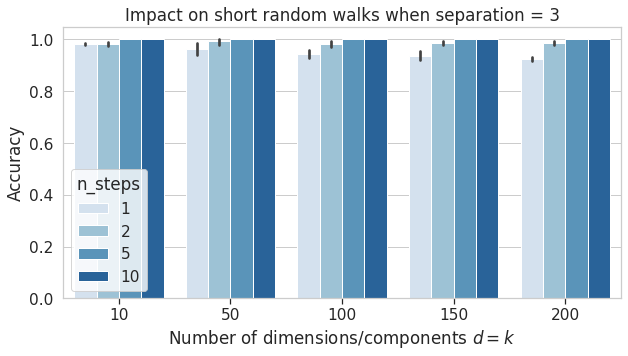

In [28]:
filter_steps_02 = df_data.experiment_name == "dim_steps_02"
df_data_filtered = df_data[filter_steps_01].copy()
df_data_filtered = df_data_filtered.sort_values(["min_distance", "n_dim", "bias_factor", "n_steps"])

with sns.plotting_context("notebook", font_scale=1.4):
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.barplot(
        x="n_dim",y="accuracy_score", hue="n_steps",
        data=df_data_filtered,palette="Blues", ax=ax
    )
    ax.yaxis.grid(True)
    ax.yaxis.set_minor_locator(ticker.LinearLocator(numticks=10))
    ax.tick_params(which="both", bottom=True)
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Number of dimensions/components $d=k$")
    ax.set_title(f"Impact on short random walks when separation = 3");
    # ax.set_ylim([0, 1])

### Impact of long walks: $\ge$ 10 steps

Experiment parameters:
- $\beta = k^{1/4}$
- Separation: 2

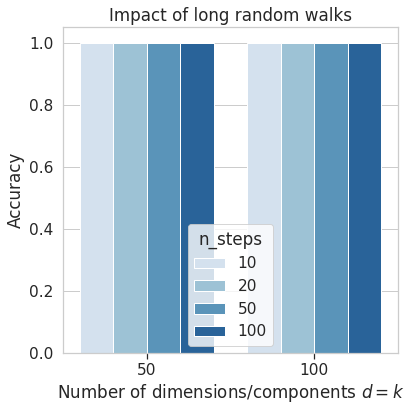

In [29]:
filter_steps_03 = df_data.experiment_name == "dim_steps_03"
filter_steps_04 = df_data.experiment_name == "dim_steps_04"
df_data_filtered = df_data[filter_steps_03 | filter_steps_04].copy()
df_data_filtered = df_data_filtered.sort_values(["min_distance", "n_dim", "bias_factor", "n_steps"])

with sns.plotting_context("notebook", font_scale=1.4):
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.barplot(
        x="n_dim",y="accuracy_score", hue="n_steps",
        data=df_data_filtered,palette="Blues", ax=ax
    )
    ax.yaxis.grid(True)
    ax.yaxis.set_minor_locator(ticker.LinearLocator(numticks=10))
    ax.tick_params(which="both", bottom=True)
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Number of dimensions/components $d=k$")
    ax.set_title(f"Impact of long random walks");
    # ax.set_ylim([0, 1])

### Impact of small separation, 1 & 1/2

Experiment parameters:
- $\beta = k^{1/4}$
- Number of steps: 10
- Separation: 1/2 or 1

In [31]:
filter_small_dist_01 = df_data.experiment_name == "small_dist_01"
df_data_filtered = df_data[filter_small_dist_01].copy()
df_data_filtered = df_data_filtered.sort_values(["min_distance", "n_dim", "bias_factor", "n_steps"])

with sns.plotting_context("notebook", font_scale=1.4):
    fig, ax = plt.subplots(figsize=(11, 6))
    sns.barplot(
        x="n_dim",y="accuracy_score",hue="min_distance",
        data=df_data_filtered,palette="Blues", ax=ax
    )
    ax.yaxis.grid(True)
    ax.yaxis.set_minor_locator(ticker.LinearLocator(numticks=10))
    ax.tick_params(which="both", bottom=True)
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Number of dimensions/components $d=k$")
    ax.set_title(f"Impact of separation on a single-step random walk");
    # ax.set_ylim([0, 1])

### Impact of separation $< 1$

Experiment parameters:
- $\beta = k^{1/4}$
- Number of steps: 10
- Separation: $\frac{1}{k^{1/m}}$ where $m = \{ 64, 16, 8, 4 \}$ 

ValueError: min() arg is an empty sequence

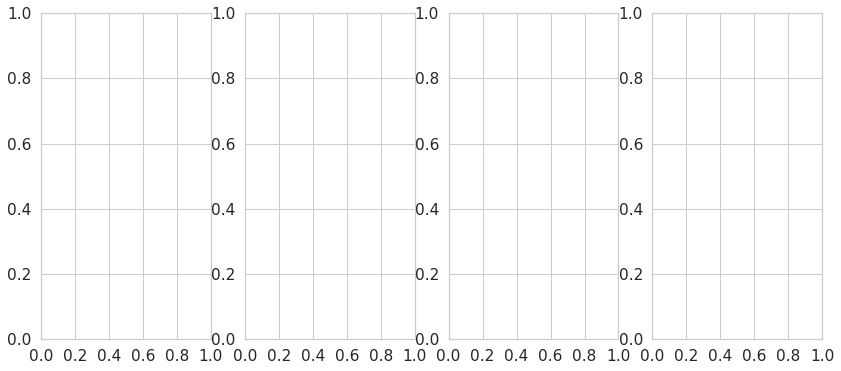

In [32]:
with sns.plotting_context("notebook", font_scale=1.4):
    fig, axes = plt.subplots(ncols=4, figsize=(14, 6))
    for i, n_dim in enumerate([10, 50, 100, 200]):
        filter_dist_below_one_01 = df_data.experiment_name == "dist_below_one_01"
        filter_dim = df_data.n_dim == n_dim
        df_data_filtered = df_data[filter_dist_below_one_01 & filter_dim].copy()
        df_data_filtered = df_data_filtered.sort_values(["min_distance", "n_dim", "bias_factor", "n_steps"])
        df_data_filtered["min_distance"] = df_data_filtered["min_distance"].round(4)
        
        sns.barplot(
            x="n_dim",y="accuracy_score",hue="min_distance",
            data=df_data_filtered,palette="Blues", ax=axes[i]
        )
        axes[i].yaxis.grid(True)
        axes[i].yaxis.set_minor_locator(ticker.LinearLocator(numticks=10))
        axes[i].tick_params(which="both", bottom=True)
        axes[i].set_ylabel("")
        axes[i].set_xlabel("")
        #axes[i].set_title(f"Impact of separation < 1");
        # ax.set_ylim([0, 1])

## Summary: no label noise

- 5 to 10 steps is enough if bias is (slightly) larger than 1
- When the labels are clean, the separation does not really matter. Even when the points in different classes are overlapping, a large enough bias will make the algorithm recover the original labels.  
